# **[1] 구매 내역 데이터**

In [ ]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from lifetimes.datasets import load_dataset

transactions = load_dataset(
    filename='CDNOW_sample.txt',
    header=None,
    delim_whitespace=True,
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)

transactions.head(3)

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96


In [ ]:
# 1997년 1월 1일~1998년 6월 30일까지 데이터
transactions.describe()

,customer_id,customer_index,date,quantity,amount
count,6919.000000,6919.000000,6919,6919.000000,6919.000000
mean,11682.515826,1175.724816,1997-06-27 18:39:41.962711424,2.381703,35.278500
min,4.000000,1.000000,1997-01-01 00:00:00,1.000000,0.000000
25%,5525.000000,570.500000,1997-02-22 00:00:00,1.000000,14.490000
50%,11749.000000,1193.000000,1997-04-15 00:00:00,2.000000,25.990000
75%,17717.000000,1766.000000,1997-10-29 12:00:00,3.000000,42.970000
max,23569.000000,2357.000000,1998-06-30 00:00:00,40.000000,506.970000
std,6833.386793,679.426450,NaN,2.218380,34.074377


In [ ]:
transactions['YM'] = transactions['date'].dt.strftime('%Y-%m')

In [ ]:
CountByYM = transactions.groupby(['YM'])['customer_id'].count().reset_index()
CountByYM.columns = ['YM', 'count']
CountByYM.iloc[:5]

,YM,count
0,1997-01,885
1,1997-02,1178
2,1997-03,1204
3,1997-04,362
4,1997-05,291


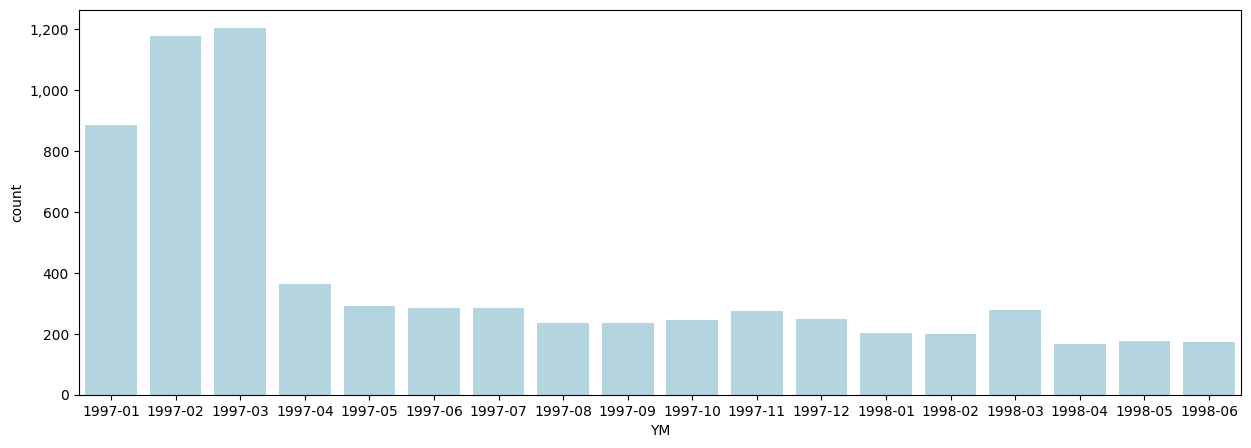

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(15, 5))

sns.barplot(data=CountByYM, x='YM', y='count', color = 'lightblue')

formatter = ticker.StrMethodFormatter("{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)

In [ ]:
# 고유 고객수 확인하기 : 2,357명
print("고유 고객수 : {0:,}(명)".format(transactions.customer_id.nunique()))

고유 고객수 : 2,357(명)


In [ ]:
transactions.iloc[:3]

,customer_id,customer_index,date,quantity,amount,YM
0,4,1,1997-01-01,2,29.33,1997-01
1,4,1,1997-01-18,2,29.73,1997-01
2,4,1,1997-08-02,1,14.96,1997-08


In [ ]:
# 1997년 데이터만 추출하기
filtered_data = transactions[transactions['date'].dt.year == 1997]

In [ ]:
print('1997년 데이터만: {0:,}(건)'.format(len(transactions)))
print('1997년 1월~1998년 6월 데이터: {0:,}(건)'.format(len(filtered_data)))

1997년 데이터만: 6,919(건)
1997년 1월~1998년 6월 데이터: 5,728(건)


In [ ]:
print('1997년 데이터에서 고유 고객수: {0:,}(명)'.format(transactions.customer_id.nunique()))
print('1997년 1월~1998년 6월 데이터에서 고유 고객수: {0:,}(명)'.format(filtered_data.customer_id.nunique()))

1997년 데이터에서 고유 고객수: 2,357(명)
1997년 1월~1998년 6월 데이터에서 고유 고객수: 2,357(명)


# **[2] 전통적 방식의 CLV 계산**

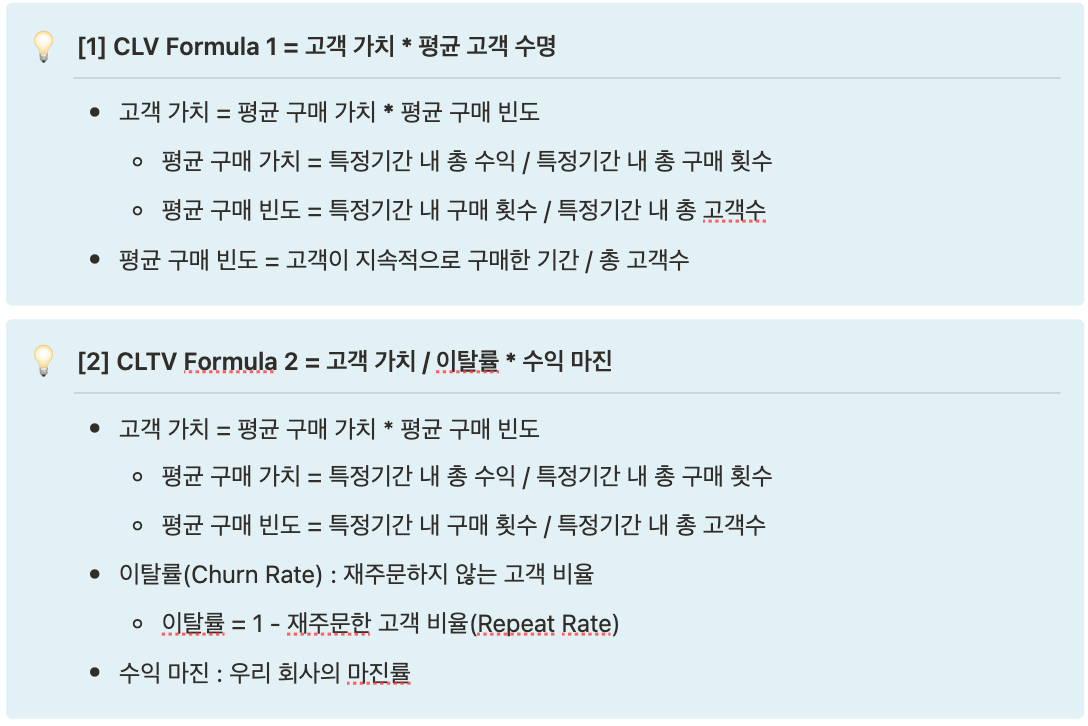

In [ ]:
# CLV 계산에 필요한 컬럼만 선별하기
filtered_data = filtered_data[['customer_id', 'date', 'quantity', 'amount']]

filtered_data['TotalPurchase'] = filtered_data['quantity'] * filtered_data['amount']

In [ ]:
# Customer Id 마다 필요한 정보 요약하기

filtered_data_group = filtered_data.groupby('customer_id').agg(
    date_range_days=('date', lambda date: (date.max() - date.min()).days),
    unique_dates=('date', lambda date: date.nunique()),
    total_quantity=('quantity', lambda quant: quant.sum()),
    total_purchase=('TotalPurchase', lambda price: price.sum())
)

In [ ]:
filtered_data_group.iloc[:3]

,date_range_days,unique_dates,total_quantity,total_purchase
customer_id,,,,
4,345,4,7,186.04
18,0,1,1,14.96
21,12,2,4,201.79


In [ ]:
# 컬럼명 바꾸기
filtered_data_group.columns = ['num_days', 'num_transactions', 'num_units', 'spent_money']
filtered_data_group.iloc[:3]

,num_days,num_transactions,num_units,spent_money
customer_id,,,,
4,345,4,7,186.04
18,0,1,1,14.96
21,12,2,4,201.79


In [ ]:
# 평균 구매가치(Average Order Value) = 총 주문액 / 총 주문횟수
filtered_data_group['avg_order_value'] = filtered_data_group['spent_money']/filtered_data_group['num_transactions']

In [ ]:
# 고유 회원수, 5컬럼
filtered_data_group.shape

(2357, 5)

In [ ]:
# 평균 구매빈도(Purchase Frequency) = 총 주문수/고유 고객수
purchase_frequency = sum(filtered_data_group['num_transactions'])/filtered_data_group.shape[0]

In [ ]:
# 재주문한 고객 비율 = 재주문한 고객수 / 총 고객수
# num_transactions이 1 이상인 경우 / 총 고객수
repeat_rate = filtered_data_group[filtered_data_group.num_transactions > 1].shape[0]/filtered_data_group.shape[0]

In [ ]:
# 이탈률(Churn Rate)
churn_rate = 1 - repeat_rate

In [ ]:
# 주문 빈도, 재주문율, 이탈률
print('주문 빈도 : {0:,.2f}(번)'.format(purchase_frequency))
print('재주문율 : {0:,.2f}(%)'.format(repeat_rate*100))
print('이탈률 : {0:,.2f}(%)'.format(churn_rate*100))

주문 빈도 : 2.35(번)
재주문율 : 44.12(%)
이탈률 : 55.88(%)


In [ ]:
# 이익마진 : (가정) 판매의 약 5%가 이익
filtered_data_group['profit_margin'] = filtered_data_group['spent_money'] * 0.05

In [ ]:
# 고객 생애가치(이익마진 포함 안한 경우) = (평균 매출액 X 주문빈도)/이탈률
filtered_data_group['CLV'] = (filtered_data_group['avg_order_value'] * purchase_frequency)/churn_rate

In [ ]:
# 고객 생애가치 = 고객가치 X 이익마진
filtered_data_group['CLTV'] = filtered_data_group['CLV'] * filtered_data_group['profit_margin']

In [ ]:
# CLTV 값 분포 살펴보기
filtered_data_group['CLTV'].describe()

count    2.357000e+03
mean     1.331918e+05
std      2.455494e+06
min      0.000000e+00
25%      6.264176e+01
50%      6.377107e+02
75%      5.321620e+03
max      8.657057e+07
Name: CLTV, dtype: float64

In [ ]:
# 백분위에 따른 구간 정의
# 상위 10%를 A
# 상위 10~40%를 B
# 상위 40~70%를 C
# 상위 70~100%를 D

quantiles = [0, 0.3, 0.6, 0.9, 1]

# 고객 생애가치 등급화하기
filtered_data_group['segment'] = pd.qcut(filtered_data_group['CLTV'], q=quantiles, labels = ['D','C','B','A'])

In [ ]:
filtered_data_group['segment'].unique()

['B', 'D', 'C', 'A']
Categories (4, object): ['D' < 'C' < 'B' < 'A']

In [ ]:
# segment 값 재정렬
filtered_data_group['segment'] = pd.Categorical(filtered_data_group['segment'], categories=['A', 'B', 'C', 'D'], ordered=True)

In [ ]:
filtered_data_group['segment'].unique()

['B', 'D', 'C', 'A']
Categories (4, object): ['A' < 'B' < 'C' < 'D']

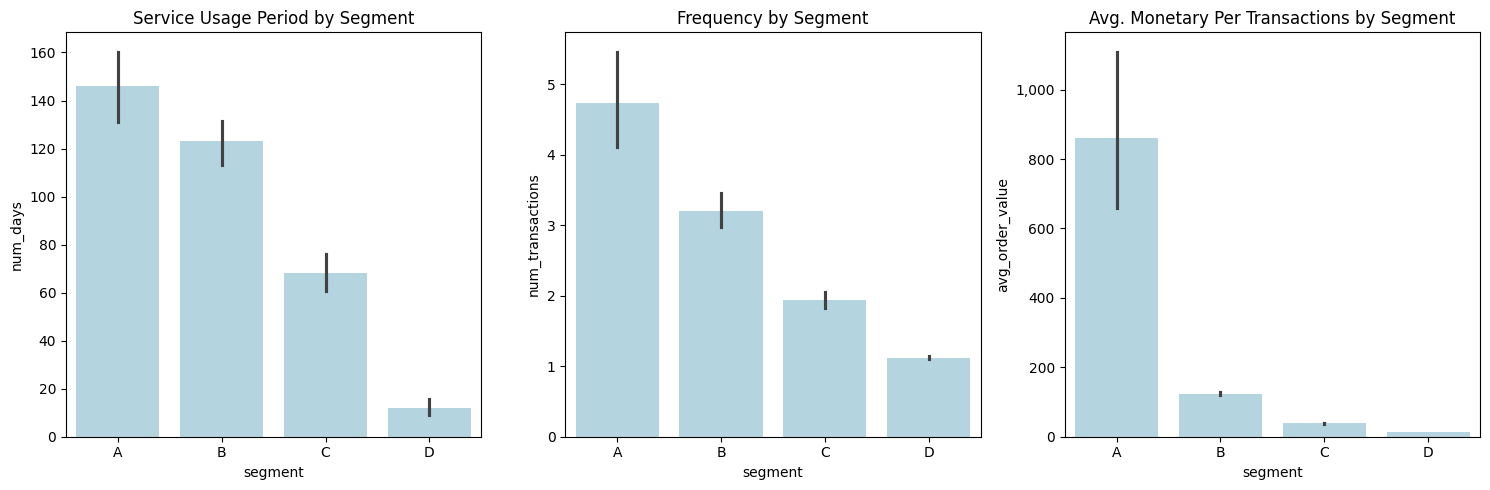

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=filtered_data_group, x='segment', y='num_days', ax=ax1, color='lightblue')
sns.barplot(data=filtered_data_group, x='segment', y='num_transactions', ax=ax2, color='lightblue')
sns.barplot(data=filtered_data_group, x='segment', y='avg_order_value', ax=ax3, color='lightblue')

ax1.set_title('Service Usage Period by Segment')
ax2.set_title('Frequency by Segment')
ax3.set_title('Avg. Monetary Per Transactions by Segment')

formatter = ticker.StrMethodFormatter("{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [ ]:
# segment 마다 필요한 정보 요약하기

filtered_data_group.groupby('segment').agg(
    customer_count=('num_days', 'count'),
    num_days_mean=('num_days', 'mean'),
    num_transactions_mean=('num_transactions', 'mean'),
    spent_money_mean=('spent_money', 'mean'),
    avg_order_value_mean=('avg_order_value', 'mean')
).round(2)

,customer_count,num_days_mean,num_transactions_mean,spent_money_mean,avg_order_value_mean
segment,,,,,
A,236,146.08,4.73,2560.93,861.58
B,707,123.03,3.21,307.30,124.37
C,707,68.08,1.93,62.29,39.06
D,707,12.03,1.12,14.70,13.25


# **[3] Regression model을 활용한 CLV 예측**
 - 1997년 1월~12월 데이터를 가지고, 1998년 전체 구매내역으로 계산한 CLV를 예측하는 선형회귀모델 만들기


In [ ]:
transactions.iloc[:3]

,customer_id,customer_index,date,quantity,amount,YM
0,4,1,1997-01-01,2,29.33,1997-01
1,4,1,1997-01-18,2,29.73,1997-01
2,4,1,1997-08-02,1,14.96,1997-08


In [ ]:
# date를 '연도-월'로 구성하기
transactions['YM'] = transactions['date'].dt.strftime('%Y-%m')

In [ ]:
transactions.iloc[:3]

,customer_id,customer_index,date,quantity,amount,YM
0,4,1,1997-01-01,2,29.33,1997-01
1,4,1,1997-01-18,2,29.73,1997-01
2,4,1,1997-08-02,1,14.96,1997-08


In [ ]:
# 각 고객 별 월 매출액 피벗 그리기
sale = transactions.pivot_table(index=['customer_id'], columns = ['YM'], values = 'amount', aggfunc='sum', fill_value=0).reset_index()

In [ ]:
sale.iloc[:2]

YM,customer_id,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
0,4,59.06,0.0,0.0,0.0,0.0,0.0,0.0,14.96,0.0,0.0,0.0,26.48,0.0,0.0,0.0,0.0,0.0,0.0
1,18,14.96,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 각 고객 별 총 매출액
sale['CLV'] = sale.iloc[:, 1:].sum(axis=1)

In [ ]:
sale.columns

Index(['customer_id', '1997-01', '1997-02', '1997-03', '1997-04', '1997-05',
       '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11',
       '1997-12', '1998-01', '1998-02', '1998-03', '1998-04', '1998-05',
       '1998-06', 'CLV'],
      dtype='object', name='YM')

In [ ]:
# 1997년에 구매를 한 번도 하지 않은 고객을 제거하기 위해서 1997-01 부터 1997-12까지 모두 0인 경우 확인
cols_to_check = sale.loc[:, '1997-01':'1997-12']
# 모두 0인 경우엔 True 그렇지 않으면 False
all_zero = (cols_to_check == 0).all(axis=1)

In [ ]:
all_zero.unique()

array([False,  True])

In [ ]:
# all_zero 정보를 sale 데이터에 추가하기
sale['all_zero_1997'] = all_zero

In [ ]:
# True인 경우(1997년에 구매를 한 번도 하지 않은 경우)가 총 8명
all_zero.value_counts()

False    2349
True        8
Name: count, dtype: int64

In [ ]:
# all_zero_1997이 False인 경우만 sale로 저장하기
sale = sale[sale['all_zero_1997'] == False]

In [ ]:
# 1997년 고객들의 주문내역(X값)을 토대로 1998년 구매내역으로 구한 CLV(Y값) 예측하기 위한 피처 선택
X = sale.loc[:, '1997-01':'1997-12']
Y=sale[['CLV']]

In [ ]:
# train/test 데이터로 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [ ]:
# Linear Regression 모델 만들기
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

In [ ]:
print(linreg.intercept_)
print(linreg.coef_)

[5.15248499]
[[0.9577557  1.05326135 0.98487336 1.2047346  1.20721994 1.24644248
  1.25413383 1.37730319 1.34184374 1.65573928 1.58470768 1.35949705]]


In [ ]:
# 최종 linear regression model 공식 만들기
intercept = linreg.intercept_[0]
coefficients = linreg.coef_[0]

period_feature = ['1997-01', '1997-02', '1997-03', '1997-04', '1997-05', '1997-06',
                  '1997-07', '1997-08', '1997-09', '1997-10', '1997-11', '1997-12']

formula = f"y = {intercept:.2f} "
for i, coef in enumerate(coefficients):
    if coef >= 0:
        formula += f"+ {coef:.2f}*{period_feature[i]} "
    else:
      formula += f" {coef:.2f}*{period_feature[i]} "

formula = formula.strip()

print(formula)

y = 5.15 + 0.96*1997-01 + 1.05*1997-02 + 0.98*1997-03 + 1.20*1997-04 + 1.21*1997-05 + 1.25*1997-06 + 1.25*1997-07 + 1.38*1997-08 + 1.34*1997-09 + 1.66*1997-10 + 1.58*1997-11 + 1.36*1997-12


In [ ]:
# R-square : 독립변수들이 종속변수를 얼마나 잘 설명하는지. 0~1 사이의 값을 가지마 1로 가까울 수록 신뢰도가 높다는 의미
# R-square 값이 0.94 라면 해당 모델이 데이터의 약 94%를 설명할 수 있다는 것을 의미

from sklearn import metrics
print('R-Square: {0:,.2f}'.format(metrics.r2_score(y_test, y_pred)))

R-Square: 0.94


In [ ]:
sale['CLV'].describe()

count    2349.000000
mean      103.913129
std       217.255409
min         3.990000
25%        19.960000
50%        43.110000
75%       105.330000
max      6552.700000
Name: CLV, dtype: float64

In [ ]:
# MAE(Mean Absolute Error) : 모델의 예측값과 실제값 차이의 절대값의 평균
# MSE(Mean Squared Error) : 모델의 예측값과 실제값 차이의 제곱의 평균(제곱을 하기 때문에 이상치에 민감)
# RMSE(Root Mean Squared Error) : MSE에 루트를 취한 값(오류 지표를 실제값과 유사한 단위로 다시 변환하기 때문에 해석이 용이

import numpy as np
print('MAE: {0:,.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('MSE: {0:,.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('RMSE: {0:,.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

MAE: 19.85
MSE: 1,665.92
RMSE: 40.82


In [ ]:
print(len(y_test))
print(len(y_pred))

588
588


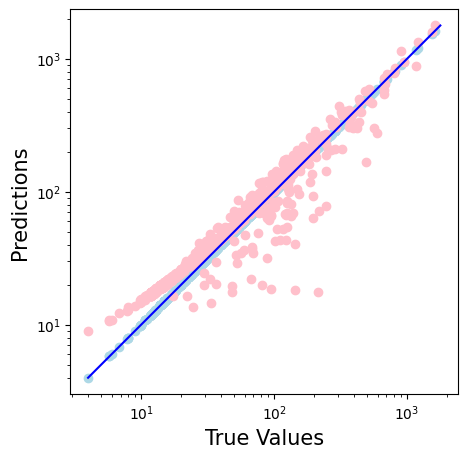

In [ ]:
# 실제값과 linear regression model이 예측한 값
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_test.values.ravel(), y_test.values.ravel(), c='lightblue', label='True Values')
plt.scatter(y_test.values.ravel(), y_pred.ravel(), c='pink', label='Predictions')

plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred.ravel()), max(y_test.values.ravel()))
p2 = min(min(y_pred.ravel()), min(y_test.values.ravel()))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
# Regression model 저장하기
import pickle

with open('RegressionModelForCLV_240727.pkl', 'wb') as f:
    pickle.dump(linreg, f)


In [ ]:
# Regression model 불러오기
#with open('RegressionModelForCLV_240727.pkl', 'rb') as f:
#    reg_model = pickle.load(f)

In [ ]:
#reg_model

LinearRegression()

# **[4] CLV BG-NBD model & Gamma-Gamma Model을 활용한 CLV 예측**

- <font color='blue'>**BG-NBD 모델**</font>은 각 고객의 구매 행동 분포를 모델링하고 각 고객의 예상 거래 수를 예측하고, <font color='blue'>**Gamma-Gamma 하위 모델**</font>은 예상 평균 이익 분포를 모델링하고 각 고객의 예상 평균 이익을 예측

In [ ]:
filtered_data.iloc[:3]

,customer_id,date,quantity,amount,TotalPurchase
0,4,1997-01-01,2,29.33,58.66
1,4,1997-01-18,2,29.73,59.46
2,4,1997-08-02,1,14.96,14.96


In [ ]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions=transactions,
                                               customer_id_col='customer_id',
                                               datetime_col='date',
                                               monetary_value_col = 'amount',
                                               freq='W',
                                               calibration_period_end='1997-12-31',
                                               observation_period_end='1998-06-30' )

In [ ]:
rfm_cal_holdout.iloc[:10]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.000000,26.0
18,0.0,0.0,52.0,0.000000,0.0,0.000000,26.0
21,1.0,2.0,52.0,11.770000,0.0,0.000000,26.0
50,0.0,0.0,52.0,0.000000,0.0,0.000000,26.0
60,0.0,0.0,48.0,0.000000,0.0,0.000000,26.0
71,0.0,0.0,52.0,0.000000,0.0,0.000000,26.0
86,0.0,0.0,52.0,0.000000,0.0,0.000000,26.0
111,8.0,48.0,52.0,84.766250,6.0,65.486667,26.0
112,1.0,5.0,52.0,11.770000,0.0,0.000000,26.0


In [ ]:
# frequency_cal과 monetary_value_cal이 0인 경우는 제외 → 제외하지 않으면 gamma-gamma model에서 오류가 발생 (gamma-gamma model에서는 양수의 값만 넣을 수 있음)
rfm_cal_holdout_v2 = rfm_cal_holdout[(rfm_cal_holdout['frequency_cal'] > 0) & (rfm_cal_holdout['monetary_value_cal'] > 0)]

In [ ]:
rfm_cal_holdout_v2.iloc[:10]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.000000,26.0
21,1.0,2.0,52.0,11.770000,0.0,0.000000,26.0
111,8.0,48.0,52.0,84.766250,6.0,65.486667,26.0
112,1.0,5.0,52.0,11.770000,0.0,0.000000,26.0
114,2.0,36.0,52.0,25.550000,1.0,28.735000,26.0
133,5.0,45.0,52.0,36.036000,0.0,0.000000,26.0
166,4.0,51.0,52.0,27.100000,3.0,11.750000,26.0
167,7.0,47.0,50.0,22.305714,0.0,0.000000,26.0
226,3.0,28.0,52.0,25.076667,2.0,29.480000,26.0


## **[4-1] BG-NBD model**

In [ ]:
from lifetimes import BetaGeoFitter

# BG-NBD model 초기 설정
bgf = BetaGeoFitter(penalizer_coef=0.01)

# BG-NBD model fitting
bgf.fit(frequency=rfm_cal_holdout_v2['frequency_cal'],
        recency=rfm_cal_holdout_v2['recency_cal'],
        T=rfm_cal_holdout_v2['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 1025 subjects, a: 0.35, alpha: 18.37, b: 0.71, r: 1.94>

In [ ]:
# bgf 모델
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.941566,0.106300,1.733218,2.149914
alpha,18.367608,1.240145,15.936924,20.798293
a,0.354782,0.043000,0.270502,0.439061
b,0.705469,0.096385,0.516554,0.894383


In [ ]:
# 6달 동안 가장 많은 구매를 할 것으로 예상되는 상위 고객 10명
bgf.conditional_expected_number_of_purchases_up_to_time(24, # 4 weeks X 6 months
                                                        rfm_cal_holdout_v2['frequency_cal'],
                                                        rfm_cal_holdout_v2['recency_cal'],
                                                        rfm_cal_holdout_v2['T_cal']).sort_values(ascending=False).head(10)


customer_id
1760     10.235843
20111     8.212260
15562     7.630348
19060     6.920007
20873     6.618899
619       6.287854
3041      6.184622
5420      5.919851
8496      5.918288
14568     5.696139
dtype: float64

<Axes: title={'center': 'Repeating Transaction Frequency'}, xlabel='Number of transactions in calibration period', ylabel='Customers'>

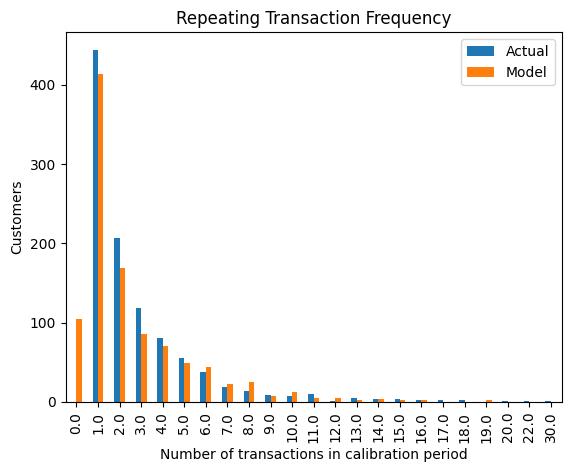

In [ ]:
# 모델이 예측한 값과 실제 데이터가 어떤지 살펴보기
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, max_frequency= 24 , title= 'Repeating Transaction Frequency' ,
    xlabel= 'Number of transactions in calibration period' ,
    ylabel= 'Customers' , label=([ "Actual" , "Model" ]))

In [ ]:
rfm_cal_holdout_v2.iloc[:10]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,n_transactions_holdout_real,n_transactions_holdout_pred
customer_id,,,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.000000,26.0,1.0,1.342860
21,1.0,2.0,52.0,11.770000,0.0,0.000000,26.0,1.0,0.044829
111,8.0,48.0,52.0,84.766250,6.0,65.486667,26.0,7.0,2.937810
112,1.0,5.0,52.0,11.770000,0.0,0.000000,26.0,1.0,0.065548
114,2.0,36.0,52.0,25.550000,1.0,28.735000,26.0,2.0,0.784937
133,5.0,45.0,52.0,36.036000,0.0,0.000000,26.0,1.0,1.911104
166,4.0,51.0,52.0,27.100000,3.0,11.750000,26.0,4.0,1.707478
167,7.0,47.0,50.0,22.305714,0.0,0.000000,26.0,1.0,2.720077
226,3.0,28.0,52.0,25.076667,2.0,29.480000,26.0,3.0,0.769016


In [ ]:
# 특정 고객 데이터로 모델 성과 살펴보기
sample_customer = rfm_cal_holdout_v2.iloc[8]
sample_customer

frequency_cal                   3.000000
recency_cal                    28.000000
T_cal                          52.000000
monetary_value_cal             25.076667
frequency_holdout               2.000000
monetary_value_holdout         29.480000
duration_holdout               26.000000
n_transactions_holdout_real     3.000000
n_transactions_holdout_pred     0.769016
Name: 226, dtype: float64

In [ ]:
# 6개월 안에 sample_customer가 주문할 횟수 예측하기
n_transactions_pred = bgf.predict(t=24, # 6개월
                                  frequency=sample_customer['frequency_cal'],
                                  recency=sample_customer['recency_cal'],
                                  T=sample_customer['T_cal'])

# bgf 모델은 6개월 안에 0.77번 주문한다고 예측함 / sample_customer는 실제로 2번 주문함
round(n_transactions_pred, 2)

0.77

In [ ]:
# 특정 고객이 교정 기간(calibration_period_end)이 끝나거나 관찰 기간(observation_period)이 시작될 때에도 여전히 활성/살아있을 확률 예측
alive_prob = bgf.conditional_probability_alive(frequency=sample_customer['frequency_cal'],
                                               recency=sample_customer['recency_cal'],
                                               T=sample_customer['T_cal'])

# sample_customer가 우리 서비스를 1997년 12월 31일까지 사용하고 있을 확률은 약 49%
round(alive_prob[0], 2)

0.49

In [ ]:
# 관찰 기간 동안의 실제 거래수는 frequency_holdout + 1
rfm_cal_holdout_v2["n_transactions_holdout_real"]  = rfm_cal_holdout_v2["frequency_holdout"] + 1

# 향후 6개월 동안 예상되는 거래수
rfm_cal_holdout_v2["n_transactions_holdout_pred"] = bgf.predict(t=24, # 4 weeks * 6 months
                                                    frequency=rfm_cal_holdout_v2['frequency_cal'],
                                                    recency=rfm_cal_holdout_v2['recency_cal'],
                                                    T=rfm_cal_holdout_v2['T_cal'])

# 실제 거래수와 bgf 모델이 예측한 거래수 비교
rfm_cal_holdout_v2[["n_transactions_holdout_real", "n_transactions_holdout_pred"]].head()

,n_transactions_holdout_real,n_transactions_holdout_pred
customer_id,,
4,1.0,1.342860
21,1.0,0.044829
111,7.0,2.937810
112,1.0,0.065548
114,2.0,0.784937


In [ ]:
# 실제 거래수와 bgf 모델이 예측한 거래수가 얼마나 차이 있는지를 살펴보기 위해서 RMSE 계산
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_true = rfm_cal_holdout_v2["n_transactions_holdout_real"],
                          y_pred = rfm_cal_holdout_v2["n_transactions_holdout_pred"],
                          squared = False)

# bgf 모델이 예측한 것과 실제 값이 약 1.67건 차이가 남
round(RMSE, 2)

1.67

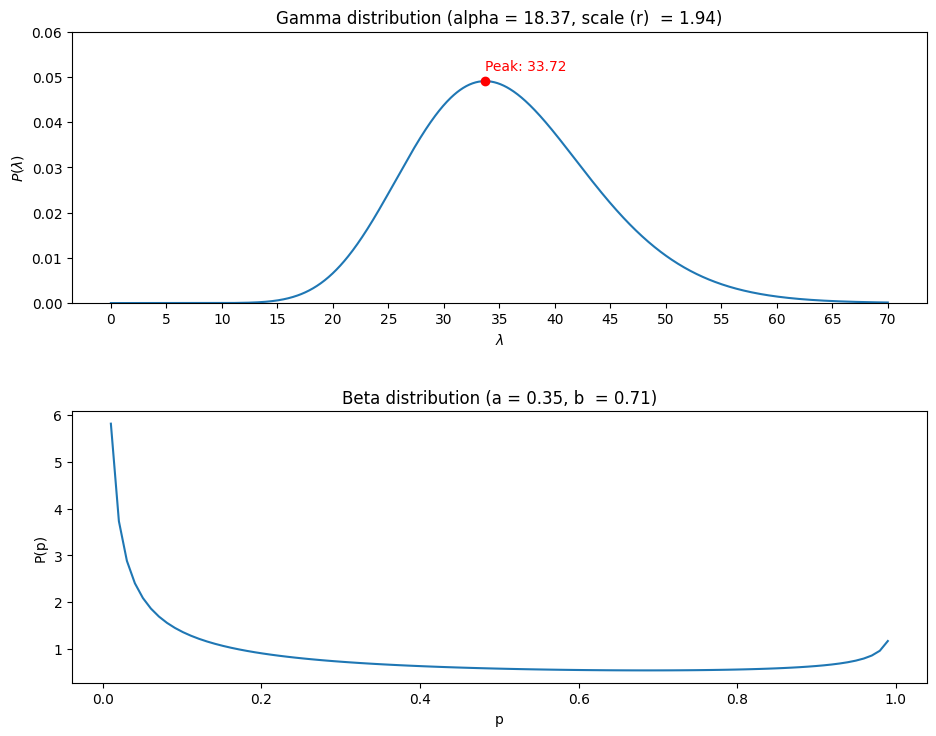

In [ ]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

# Gamma 분포 및 Beta 분포 최빈값 계산
alpha = bgf.params_["alpha"]
scale = bgf.params_["r"]
mode_gamma = (alpha - 1) * scale if alpha > 1 else 0

fig, (ax_gamma, ax_beta) = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))

# Gamma 분포 그래프
x_gamma = np.linspace(0, 70, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=alpha, scale=scale)
ax_gamma.set_ylim(0, 0.06)
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma distribution (alpha = {alpha:.2f}, scale (r)  = {scale:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')
ax_gamma.set_xticks(np.arange(0, 71, 5))

# Gamma 분포 최빈값 추가
ax_gamma.plot(mode_gamma, stats.gamma.pdf(mode_gamma, a=alpha, scale=scale), 'ro')  # 점 추가
ax_gamma.text(mode_gamma, stats.gamma.pdf(mode_gamma, a=alpha, scale=scale) * 1.05, f'Peak: {mode_gamma:.2f}', color='red')  # 라벨 추가

# Beta 분포 그래프
x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=a, b=b)
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {a:.2f}, b  = {b:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')

fig.tight_layout(pad=3.0)
plt.show()


**<font color='blue'>[Gamma Distribution 해석]</font>**<br>
- Gamma 분포의 경우, 𝜆는 **고객의 구매빈도(rate of purchasing)**을 나타냄.
- Gamma 분포에서 최빈값을 구하는 공식 : (𝛼 - 1) X scale
- Gamma 분포에서 33.72일 때 Peak(최빈값)임. 즉, 고객은 1997년 일년 동안 33회 주문하는 고객이 가장 많았다는 것을 의미함.

**<font color='blue'>[Beta Distribution 해석]</font>**<br>
- Beta 분포는 **고객의 탈퇴 확률**을 나타냄.
- a(0.35)가 b(0.71)보다 작으므로, 분포는 p=0에 더 가까운 값에 치우쳐 있고, U자형임. 즉, 고객이 구매를 계속할 확률이 낮음을 의미함(고객의 탈퇴 확률이 상대적으로 높다는 것을 의미)

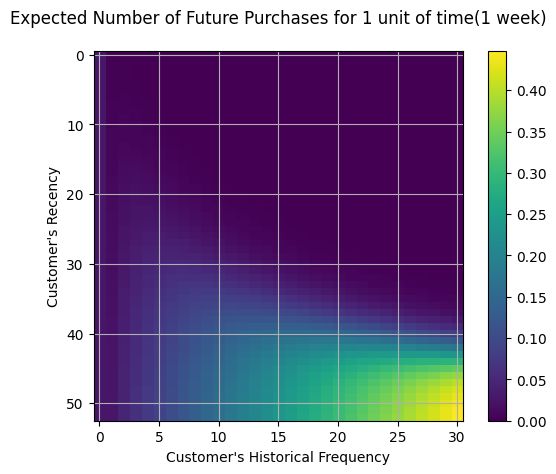

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

ax = plt.gca()

ax.grid(True)

ax.set_title("Expected Number of Future Purchases for 1 unit of time(1 week)", pad=20)

plt.show()

**<font color='blue'>[plot_frequency_recency_matrix 해석]</font>**<br>
- 고객이 일주일에 25번 구매한 적이 있고, 가장 최근 구매로부터 40주 이상 시간이 지났다면 다시 우리 서비스를 다시 이용할 가능성이 높은 고객(오른쪽 하단)

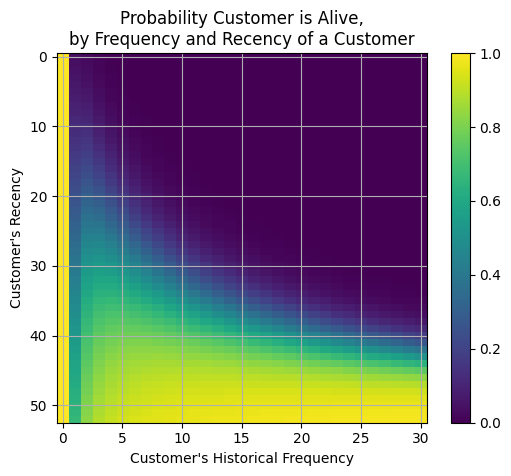

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

ax = plt.gca()

ax.grid(True)

plt.show()

**<font color='blue'>[plot_probability_alive_matrix 해석]</font>**<br>
- (좌측 상단) : 일회성 고객 : Low Frequency, Low Recency (구매 횟수가 적고, 마지막 구매가 비교적 최근)
- (좌측 하단) : 신규 고객 : Low Frequency, High Recency (구매 횟수가 적고, 마지막 구매가 오래 전)
- (우측 상단) : 충성고객이지만 위험 : High Frequency, Low Recency (구매 횟수가 많지만, 마지막 구매가 비교적 최근)
- (우측 하단) : 충성 고객 : High Frequency, High Recency (구매 횟수가 많고, 마지막 구매가 오래 전)

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

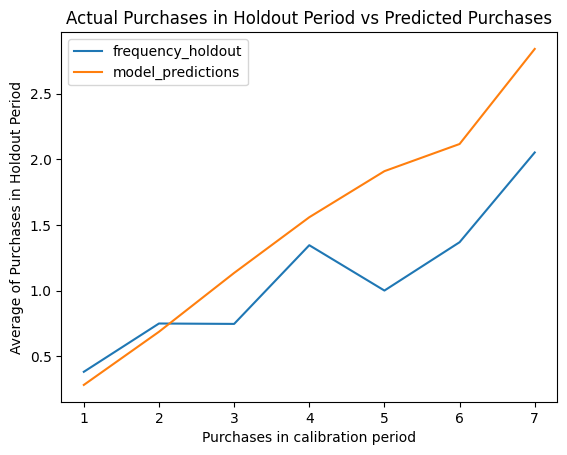

In [ ]:
# 모델이 예측한 것과 실제값 비교하기
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(bgf, rfm_cal_holdout_v2)

In [ ]:
# 모델 저장하기
bgf.save_model('bgf.pkl')

# 모델 불러오기
#bgf_loaded = BetaGeoFitter()
#bgf_loaded.load_model('bgf.pkl')
#bgf_loaded

## **[4-2] Gamma-Gamma model**

In [ ]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(rfm_cal_holdout_v2['frequency_cal'], rfm_cal_holdout_v2['monetary_value_cal'])

<lifetimes.GammaGammaFitter: fitted with 1025 subjects, p: 4.08, q: 0.93, v: 3.78>

In [ ]:
# 가장 가치 있을 것으로 예상되는 상위 고객 10명
ggf.conditional_expected_average_profit(rfm_cal_holdout_v2['frequency_cal'],
                                        rfm_cal_holdout_v2['monetary_value_cal']).sort_values(ascending=False).head(10)

customer_id
19339    1263.341229
3902      250.850236
2761      245.525833
314       234.747405
1417      221.762735
7726      209.068270
10355     207.269637
4287      196.625173
16324     193.189089
8736      186.080613
dtype: float64

In [ ]:
rfm_cal_holdout_v2.iloc[:3]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,n_transactions_holdout_real,n_transactions_holdout_pred
customer_id,,,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.000000,26.0,1.0,1.342860
21,1.0,2.0,52.0,11.770000,0.0,0.000000,26.0,1.0,0.044829
111,8.0,48.0,52.0,84.766250,6.0,65.486667,26.0,7.0,2.937810


In [ ]:
# ggf 모델 저장하기
ggf.save_model('ggf.pkl')

In [ ]:
# ggf 모델 불러오기
ggf_loaded = GammaGammaFitter()
ggf_loaded.load_model('ggf.pkl')
ggf_loaded

## **[4-3] BG-NBD 모델과 GGF 모델을 활용하여 고객 생애가치 예측하기**

In [ ]:
# 향후 6개월 동안 예상되는 고객 생애가치
rfm_cal_holdout_v2['cltv_pred_6_months'] = ggf.customer_lifetime_value(bgf,
                                                                        rfm_cal_holdout_v2['frequency_cal'],
                                                                        rfm_cal_holdout_v2['recency_cal'],
                                                                        rfm_cal_holdout_v2['T_cal'],
                                                                        rfm_cal_holdout_v2['monetary_value_cal'],
                                                                        time=24,  # 6개월
                                                                        freq="W",  # 주 설정
                                                                        discount_rate=0.01)

In [ ]:
rfm_cal_holdout_v2.iloc[:3]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,n_transactions_holdout_real,n_transactions_holdout_pred,cltv_pred_6_months,segment
customer_id,,,,,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.000000,26.0,1.0,1.342860,110.973222,B
21,1.0,2.0,52.0,11.770000,0.0,0.000000,26.0,1.0,0.044829,2.254259,D
111,8.0,48.0,52.0,84.766250,6.0,65.486667,26.0,7.0,2.937810,841.619958,A


In [ ]:
# 고객 생애가치 등급화하기
# 백분위에 따른 구간 정의
# 상위 10%를 A
# 상위 10~40%를 B
# 상위 40~70%를 C
# 상위 70~100%를 D

quantiles = [0, 0.3, 0.6, 0.9, 1]

rfm_cal_holdout_v2['segment'] = pd.qcut(rfm_cal_holdout_v2['cltv_pred_6_months'], q=quantiles, labels = ['D','C','B','A'])
rfm_cal_holdout_v2['segment'] = rfm_cal_holdout_v2['segment'].cat.reorder_categories(['A', 'B', 'C', 'D'], ordered=True)

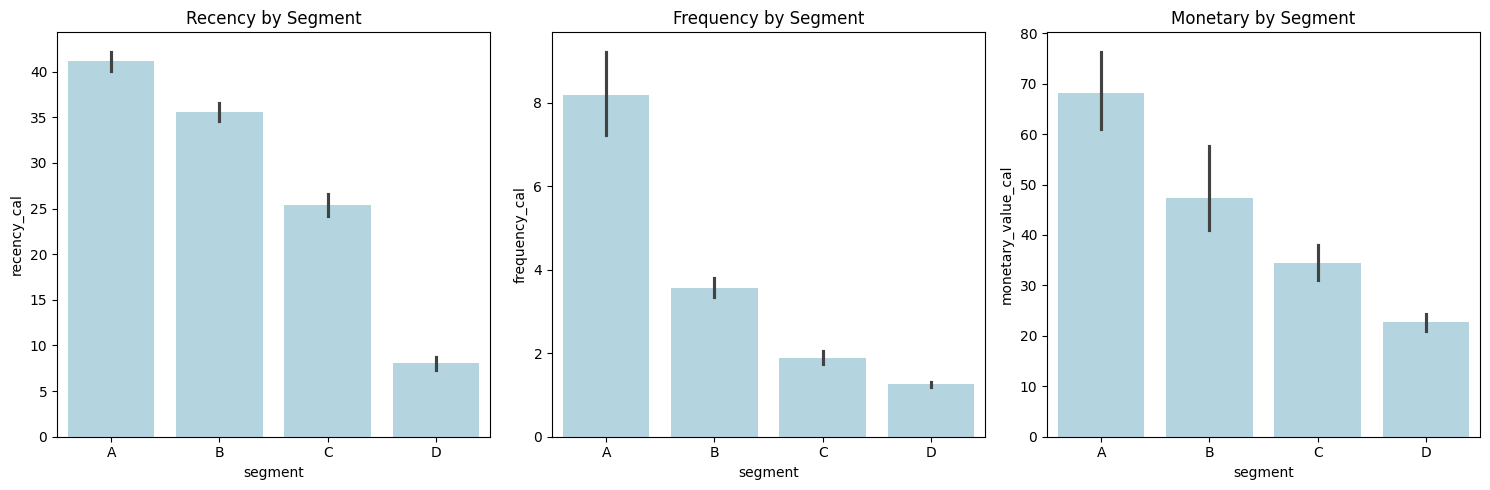

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=rfm_cal_holdout_v2, x='segment', y='recency_cal', ax=ax1, color='lightblue')
sns.barplot(data=rfm_cal_holdout_v2, x='segment', y='frequency_cal', ax=ax2, color='lightblue')
sns.barplot(data=rfm_cal_holdout_v2, x='segment', y='monetary_value_cal', ax=ax3, color='lightblue')

ax1.set_title('Recency by Segment')
ax2.set_title('Frequency by Segment')
ax3.set_title('Monetary by Segment')

formatter = ticker.StrMethodFormatter("{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()



In [ ]:
# segment 마다 필요한 정보 요약하기
# 1997년 1월~12월까지의 고객 정보 요약

rfm_cal_holdout_v2.groupby('segment').agg(
    customer_count=('recency_cal', 'count'),
    recency_mean=('recency_cal', 'mean'),
    frequency_mean=('frequency_cal', 'mean'),
    monetary_mean=('monetary_value_cal', 'mean')
).round(2)

,customer_count,recency_mean,frequency_mean,monetary_mean
segment,,,,
A,103,41.13,8.19,68.15
B,307,35.61,3.57,47.37
C,307,25.40,1.90,34.52
D,308,8.06,1.25,22.70


In [ ]:
# segment 마다 필요한 정보 요약하기
# 1998년 1월~6월까지의 고객 정보 요약

rfm_cal_holdout_v2.groupby('segment').agg(
    customer_count=('cltv_pred_6_months', 'count'),
    cltv_value_mean=('cltv_pred_6_months', 'mean'),
    frequency_mean=('frequency_holdout', 'mean'),
    monetary_mean=('monetary_value_holdout', 'mean')
).round(2)

,customer_count,cltv_value_mean,frequency_mean,monetary_mean
segment,,,,
A,103,600.10,3.01,42.46
B,307,164.33,1.17,20.30
C,307,47.14,0.62,10.41
D,308,10.19,0.31,5.17
